## Make SST SIC forcings for CESM F1850 compset

---
2023-12 YitaoLIU

## Import Pkgs

In [1]:
import numpy as np
import xarray as xr
import datetime

import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt


%matplotlib inline

# My Functions

## sub functions

In [2]:
def fill_missing_by_ref(data_with_nan, data_fill):
    # missing values exit in data_with_nan, fill the NaN with the corresponding value in data_fill
    data_with_nan_value = data_with_nan.values

    data_with_nan_value[np.isnan(data_with_nan_value)] = data_fill.values[np.isnan(data_with_nan_value)]
    data = data_with_nan.copy()
    data.values = data_with_nan_value
    return data

def shift_1year_to_3year_cycle(data_0a):
    data_1a = data_0a.copy()
    data_m1a = data_0a.copy()
    data_1a = data_1a.assign_coords(time=data_0a.time.values + datetime.timedelta(days=365))
    data_m1a = data_m1a.assign_coords(time=data_0a.time.values - datetime.timedelta(days=365))
    data_m1_0_1a = xr.concat([data_m1a, data_0a, data_1a], dim='time')
    return data_m1_0_1a

def annual_cycle_effect(data_0a, data_ori):
    time_index = data_0a['time'].copy()
    # print(time_index)
    year_str   = "{:0>4d}".format(time_index.dt.year[0])
    data_3a       = shift_1year_to_3year_cycle(data_0a)
    data_3a_daily = data_3a.resample(time='1D').interpolate('linear')
    data_3a_daily_to_0a = data_3a_daily.sel(time=slice(f'{year_str}-01-01',f'{year_str}-12-31'))
    data_0a_monthly = data_3a_daily_to_0a.groupby('time.month').mean().rename({'month':'time'})
    data_0a_monthly = data_0a_monthly.assign_coords(time=time_index.values)
    annual_cycle_effect = data_ori - data_0a_monthly
    return annual_cycle_effect

def clip_sst(data):
    data = data.where(data>-1.8)
    data = data.where(data<33)
    return data

## def func to remove Annual Cycle effect
### detail in: 

Sheng, J., & Zwiers, F. (1998). An improved scheme for time-dependent 

boundary conditions in atmospheric general circulation models. 

Climate Dynamics, 14(7), 609–613. https://doi.org/10.1007/s003820050244

### NOTE: 

meet the same goal , BUT with absolutely different method, 

thanks to the boost of computing power today (2023)

In [3]:
def remove_annual_cycle_effect(data_ori, datatpye='sst'):
    '''
    data_ori: xarray Dataarray
    datatpye: 'sst' or 'sic'
    '''
    data_output = data_ori.copy()
    ## remove annual cycle effect 1st time
    AC_effect_1st_time = annual_cycle_effect(data_ori, data_ori)
    data_output.values = data_output.values + AC_effect_1st_time.values

    ## it seems that doing this for another 3 times is enough
    ## (can be modified to whatever you want)
    times_for_loop = 5
    for ii in range(times_for_loop):
        AC_effect = annual_cycle_effect(data_output, data_ori)
        data_output.values = data_output.values + AC_effect.values
    
    ##-------------------------------
    ## clip the data with physical meaning
    if datatpye == 'sst':
        ### SST not less than -1.77
        data_output = data_output.where(data_output>-1.77, -1.77)
        print(f'sst min = {data_output.min().values}')
    elif datatpye == 'sic':
        ### SIC not less than 0, not larger than 1
        data_output = data_output.where(data_output>0., 0.0000000001).where(data_output<1., 0.99999999999)
        print(f'sic min = {data_output.min().values}')
        print(f'sic max = {data_output.max().values}')
    else:
        print('datatpye should be sst or sic')

    AC_effect = annual_cycle_effect(data_output, data_ori)
    ##-------------------------------
    ## check the result some where 
    ## (can be modified to whereever you want)
    test_lat = 40.
    test_lon = 150.
    data_ori.sel(
                lat=test_lat, lon=test_lon, method='nearest'
                ).plot(label='prediddle', drawstyle='steps-mid')
    data_output.sel(
                   lat=test_lat, lon=test_lon, method='nearest'
                   ).plot(label=f'after {times_for_loop+1} times\nremoving AC effect')
    plt.legend()
    plt.show()
    AC_effect_1st_time.sel(
                            lat=test_lat, lon=test_lon, method='nearest'
                            ).plot(label='AC effect ori_data')
    AC_effect.sel(
                 lat=test_lat, lon=test_lon, method='nearest'
                 ).plot(label=f'AC effect {times_for_loop+1} times')
    plt.legend()
    plt.show()
    return data_output

    

## dec func to make forcing data

In [4]:
def make_forcing_data(sst_forcing, sci_forcing, sst_sic_sample):
    ds_out = sst_sic_sample.copy()
    sst_fill = fill_missing_by_ref(sst_forcing, sst_sic_sample['SST_cpl_prediddle'])
    sic_fill = fill_missing_by_ref(sci_forcing, sst_sic_sample['ice_cov_prediddle'])
    ds_out['SST_cpl_prediddle'].values = sst_fill.values
    ds_out['ice_cov_prediddle'].values = sic_fill.values
    sst_out     = remove_annual_cycle_effect(sst_fill, datatpye='sst')
    sic_out     = remove_annual_cycle_effect(sic_fill, datatpye='sic')
    ds_out['SST_cpl'].values = sst_out.values
    ds_out['ice_cov'].values = sic_out.values
    ds_out.attrs['history'] = 'Artificially diddled by YitaoLIU'
    return ds_out

## Import Data

In [5]:
## for original SST SIC 
sst_ice_ori = xr.open_dataset('./ref_nc/sst_HadOIBl_bc_1x1_clim_pi_c101029.nc', use_cftime=True)

# import my forcing data

In [40]:
ex_name = 'sample_PI'
time_range = '0001-0100'
sst_PI = xr.open_dataset(f'./{ex_name}.OClim.ocn.SST.1x1.{time_range}.monthly.nc')['SST']
ice_PI = xr.open_dataset(f'./{ex_name}.OClim.ocn.IFRAC.1x1.{time_range}.monthly.nc')['IFRAC']

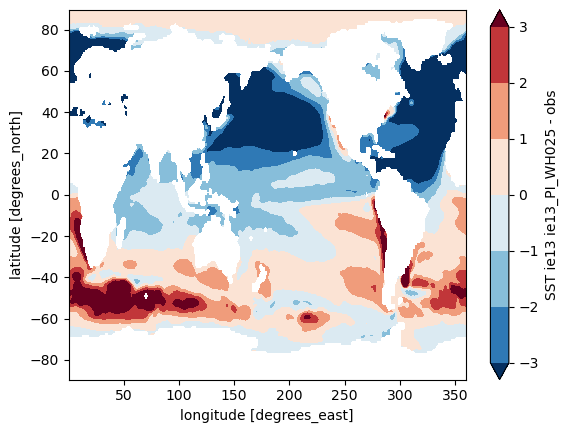

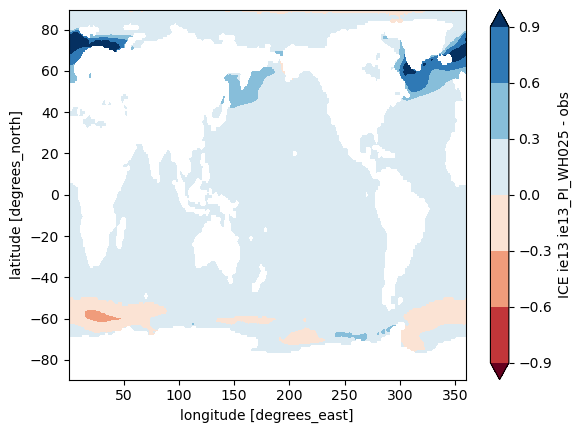

In [41]:
(sst_PI.mean(dim='time') - 
 sst_ice_ori['SST_cpl_prediddle'].mean(dim='time')).rename(
     f'SST ie13 {ex_name} - obs').plot.contourf(
         vmin=-3,vmax=3,cmap='RdBu_r',extend='both')
plt.show()

(ice_PI.mean(dim='time') - 
 sst_ice_ori['ice_cov_prediddle'].mean(dim='time')).rename(
     f'ICE ie13 {ex_name} - obs').plot.contourf(
         vmin=-0.9,vmax=0.9,cmap='RdBu',extend='both')
plt.show()

# DO

sst min = -1.77


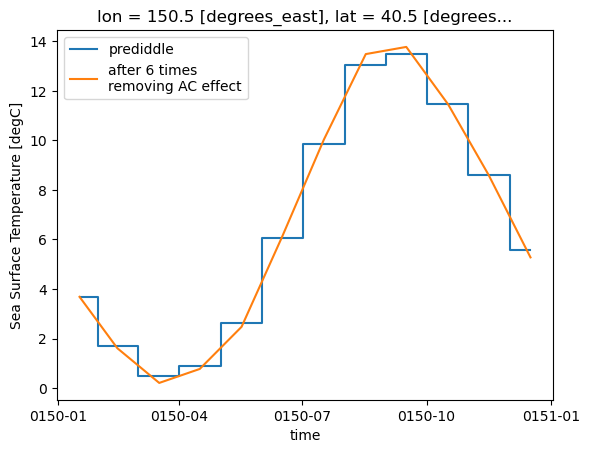

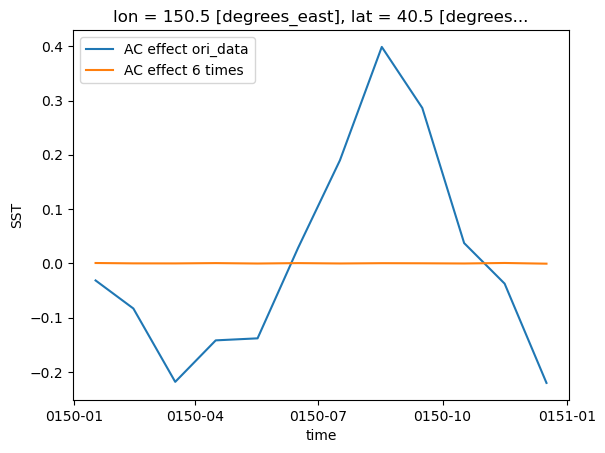

sic min = 1.4177132070687756e-25
sic max = 0.99999999999


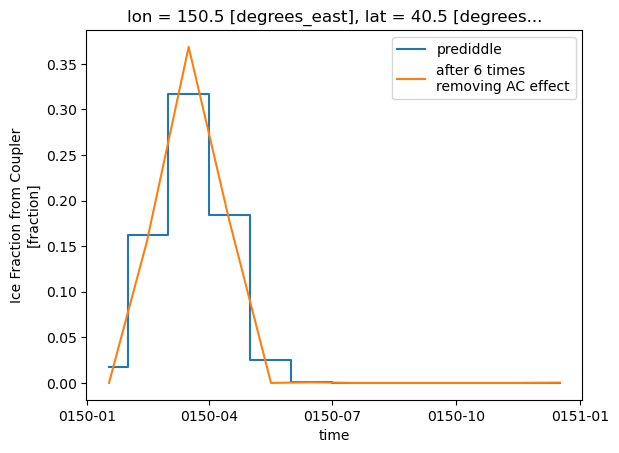

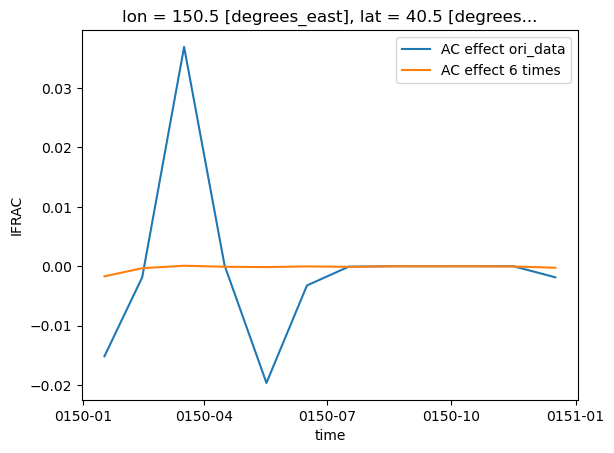

In [42]:
ds_out = make_forcing_data(sst_PI, ice_PI, sst_ice_ori)
ds_out.to_netcdf(
    f'./{ex_name}_{time_range}_sst_ice_force.nc', 
    format='NETCDF3_CLASSIC', mode='w')